**Credit Scoring Model:**
This model uses a [ Kaggle Dataset](https://www.kaggle.com/c/GiveMeSomeCredit) about credit repayment difficulty rates among customers 



In [667]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='white', context='notebook', palette='deep')
from collections import Counter

In [668]:
train_df = pd.read_csv('cs-training.csv')
train_df.shape

(150000, 12)

In [669]:
test_df = pd.read_csv('cs-test.csv')
test_df.shape

(101503, 12)

In [670]:
train_df.head()

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
1,2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
2,3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
3,4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
4,5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


**DATASET VARIABLES**

**SeriousDlqin2yrs (Target variable)** : Person experienced 90 days past due delinquency or worse

**RevolvingUtilizationOfUnsecuredLines** : Total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits

**age** : Age of borrower in years

**NumberOfTime30-59DaysPastDueNotWorse** : Number of times borrower has been 30-59 days past due but no worse in the last 2 years.

**DebtRatio** : Monthly debt payments, alimony,living costs divided by monthy gross income

**MonthlyIncome** : Monthly income

**NumberOfOpenCreditLinesAndLoans** : Number of Open loans (installment like car loan or mortgage) and Lines of credit (e.g. credit cards)

**NumberOfTimes90DaysLate** : Number of times borrower has been 90 days or more past due.

**NumberRealEstateLoansOrLines** : Number of mortgage and real estate loans including home equity lines of credit

**NumberOfTime60-89DaysPastDueNotWorse** : Number of times borrower has been 60-89 days past due but no worse in the last 2 years.

**NumberOfDependents** : Number of dependents in family excluding themselves (spouse, children etc.)

**Understanding Data**


In [671]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 12 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   Unnamed: 0                            150000 non-null  int64  
 1   SeriousDlqin2yrs                      150000 non-null  int64  
 2   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 3   age                                   150000 non-null  int64  
 4   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 5   DebtRatio                             150000 non-null  float64
 6   MonthlyIncome                         120269 non-null  float64
 7   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 8   NumberOfTimes90DaysLate               150000 non-null  int64  
 9   NumberRealEstateLoansOrLines          150000 non-null  int64  
 10  NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 11  

In [672]:
train_df.isnull().sum()

Unnamed: 0                                  0
SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30-59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60-89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [673]:
test_df.isnull().sum()

Unnamed: 0                                   0
SeriousDlqin2yrs                        101503
RevolvingUtilizationOfUnsecuredLines         0
age                                          0
NumberOfTime30-59DaysPastDueNotWorse         0
DebtRatio                                    0
MonthlyIncome                            20103
NumberOfOpenCreditLinesAndLoans              0
NumberOfTimes90DaysLate                      0
NumberRealEstateLoansOrLines                 0
NumberOfTime60-89DaysPastDueNotWorse         0
NumberOfDependents                        2626
dtype: int64

In test dataset the target variable also contains some null values.

First we have to either fill these missing values or remove the missing values data. Here we are replacing the missing values with the median in 'MonthlyIncome' column after removing the outliers if any, and with 0 in 'NumberOfdependents' column in the traing dataset.

In [674]:
train_df.MonthlyIncome.median()

5400.0

In [675]:
test_df.MonthlyIncome.median()

5400.0

In [676]:
train_df.MonthlyIncome = train_df.MonthlyIncome.fillna(train_df.MonthlyIncome.median())
test_df.MonthlyIncome = test_df.MonthlyIncome.fillna(test_df.MonthlyIncome.median())

In [677]:
train_df.NumberOfDependents = train_df.NumberOfDependents.fillna(train_df.NumberOfDependents.median())
test_df.NumberOfDependents = test_df.NumberOfDependents.fillna(test_df.NumberOfDependents.median())

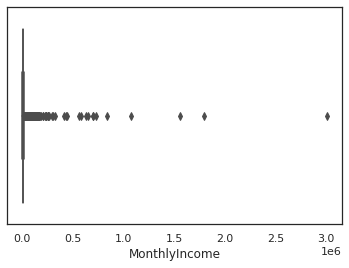

In [678]:
# Boxplot to check for the outliers
sns.boxplot(train_df['MonthlyIncome'])

We can clearly see the presence of outliers in 'MonthlyIncome' column.
Let's write code to remove the outliers from all the numerical columns present in the dataset using Interquartile range (IQR).

In [679]:
def detect_outliers(df,n,features):
    outlier_indices = []
    
    # iterate over features(columns)
    for col in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[col], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[col],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        
        # Determine a list of indices of outliers for feature col
        outlier_list_col = df[(df[col] < Q1 - outlier_step) | (df[col] > Q3 + outlier_step )].index
        
        # append the found outlier indices for col to the list of outlier indices 
        outlier_indices.extend(outlier_list_col)
        
    # select observations containing more than 2 outliers
    outlier_indices = Counter(outlier_indices)        
    multiple_outliers = list( k for k, v in outlier_indices.items() if v > n )
    
    return multiple_outliers

In [680]:
detected_outliers = detect_outliers(train_df,2,["RevolvingUtilizationOfUnsecuredLines",
                                            "age",
                                            "NumberOfTime30-59DaysPastDueNotWorse",
                                            "DebtRatio",
                                            "MonthlyIncome",
                                            "NumberOfOpenCreditLinesAndLoans",
                                            "NumberOfTimes90DaysLate",
                                            "NumberRealEstateLoansOrLines",
                                            "NumberOfTime60-89DaysPastDueNotWorse",
                                            "Unnamed: 0",
                                            "NumberOfDependents"])

In [681]:
train_df.loc[detected_outliers]

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
900,901,0,2.258964,33,2,0.032484,2000.0,1,1,0,0,2.0
919,920,1,1.362142,73,1,274.000000,5400.0,2,3,0,1,0.0
1958,1959,0,1.634551,28,0,151.000000,5400.0,1,3,0,2,0.0
4793,4794,0,3746.000000,52,2,0.481353,2600.0,5,0,1,0,3.0
4852,4853,0,1.566866,46,2,0.104983,6000.0,3,2,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
142226,142227,1,0.859714,55,0,0.599348,11046.0,18,7,6,6,1.0
142830,142831,0,0.889452,47,0,0.411026,8833.0,13,3,1,1,3.0
143782,143783,1,1.000000,38,0,0.250573,5666.0,4,2,1,1,3.0
146360,146361,0,0.921219,45,0,0.092564,3845.0,3,1,0,1,3.0


In [682]:
train_df = train_df.drop(detected_outliers, axis = 0).reset_index(drop=True)

In [683]:
train_df.shape

(144793, 12)

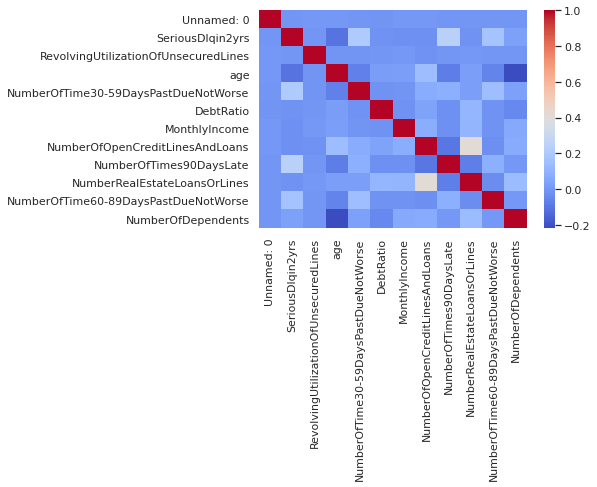

In [684]:
# Correlation matrix
g = sns.heatmap(train_df.corr(),annot=False, fmt = ".2f", cmap = "coolwarm")

In [685]:
train_df.corr(method='spearman')

,Unnamed: 0,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
Unnamed: 0,1.000000,0.000925,-0.004502,0.004545,0.000859,-0.000872,0.001518,0.004633,-0.004994,-0.001615,0.001177,-0.000926
SeriousDlqin2yrs,0.000925,1.000000,0.206985,-0.107541,0.186670,0.005924,-0.060144,-0.024916,0.248020,-0.028045,0.166578,0.036674
RevolvingUtilizationOfUnsecuredLines,-0.004502,0.206985,1.000000,-0.273613,0.189235,0.075496,-0.061229,-0.070945,0.178051,-0.016532,0.118185,0.118951
age,0.004545,-0.107541,-0.273613,1.000000,-0.080312,0.026359,0.102787,0.149941,-0.082838,0.044309,-0.062184,-0.232262
NumberOfTime30-59DaysPastDueNotWorse,0.000859,0.186670,0.189235,-0.080312,1.000000,0.020798,-0.014345,0.076909,0.097467,0.025817,0.119626,0.050001
DebtRatio,-0.000872,0.005924,0.075496,0.026359,0.020798,1.000000,-0.094914,0.226826,-0.057760,0.405013,-0.021645,-0.059114
MonthlyIncome,0.001518,-0.060144,-0.061229,0.102787,-0.014345,-0.094914,1.000000,0.267127,-0.076734,0.344247,-0.041885,0.186137
NumberOfOpenCreditLinesAndLoans,0.004633,-0.024916,-0.070945,0.149941,0.076909,0.226826,0.267127,1.000000,-0.117008,0.465272,-0.025526,0.110426
NumberOfTimes90DaysLate,-0.004994,0.248020,0.178051,-0.082838,0.097467,-0.057760,-0.076734,-0.117008,1.000000,-0.093082,0.079929,0.010526
NumberRealEstateLoansOrLines,-0.001615,-0.028045,-0.016532,0.044309,0.025817,0.405013,0.344247,0.465272,-0.093082,1.000000,-0.033292,0.173724


We can see that the Target variable has the highest correlation with 'NumberOfTimes90DaysLate', 'NumberOfTime60-89DaysPastDueNotWorse', and 'RevolvingUtilizationOfUnsecuredLines'. So we will first investigate 'RevolvingUtilizationOfUnsecuredLines' more.



In [686]:
train_df.RevolvingUtilizationOfUnsecuredLines.describe()

count    144793.000000
mean          5.555829
std         242.303458
min           0.000000
25%           0.028492
50%           0.143735
75%           0.524501
max       50708.000000
Name: RevolvingUtilizationOfUnsecuredLines, dtype: float64

In [687]:
train_df = train_df.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})
test_df = test_df.rename(columns={'Unnamed: 0': 'Unknown',
                                  'SeriousDlqin2yrs': 'Target',
                                  'RevolvingUtilizationOfUnsecuredLines': 'UnsecLines',
                                  'NumberOfTime30-59DaysPastDueNotWorse': 'Late3059',
                                  'DebtRatio': 'DebtRatio',
                                  'MonthlyIncome': 'MonthlyIncome',
                                  'NumberOfOpenCreditLinesAndLoans': 'OpenCredit',
                                  'NumberOfTimes90DaysLate': 'Late90',
                                  'NumberRealEstateLoansOrLines': 'PropLines',
                                  'NumberOfTime60-89DaysPastDueNotWorse': 'Late6089',
                                  'NumberOfDependents': 'Deps'})

In [688]:
## Separate train features and label 
train_df["Target"] = train_df["Target"].astype(int)
X_train = train_df.drop(labels = ["Target", "Unknown"],axis = 1)
Y_train = train_df["Target"]

In [689]:
X_train.isnull().sum()

UnsecLines       0
age              0
Late3059         0
DebtRatio        0
MonthlyIncome    0
OpenCredit       0
Late90           0
PropLines        0
Late6089         0
Deps             0
dtype: int64

In [690]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50, max_features='sqrt')
clf = clf.fit(X_train, Y_train)

In [691]:
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort_values(by=['importance'], ascending=True, inplace=True)
features.set_index('feature', inplace=True)

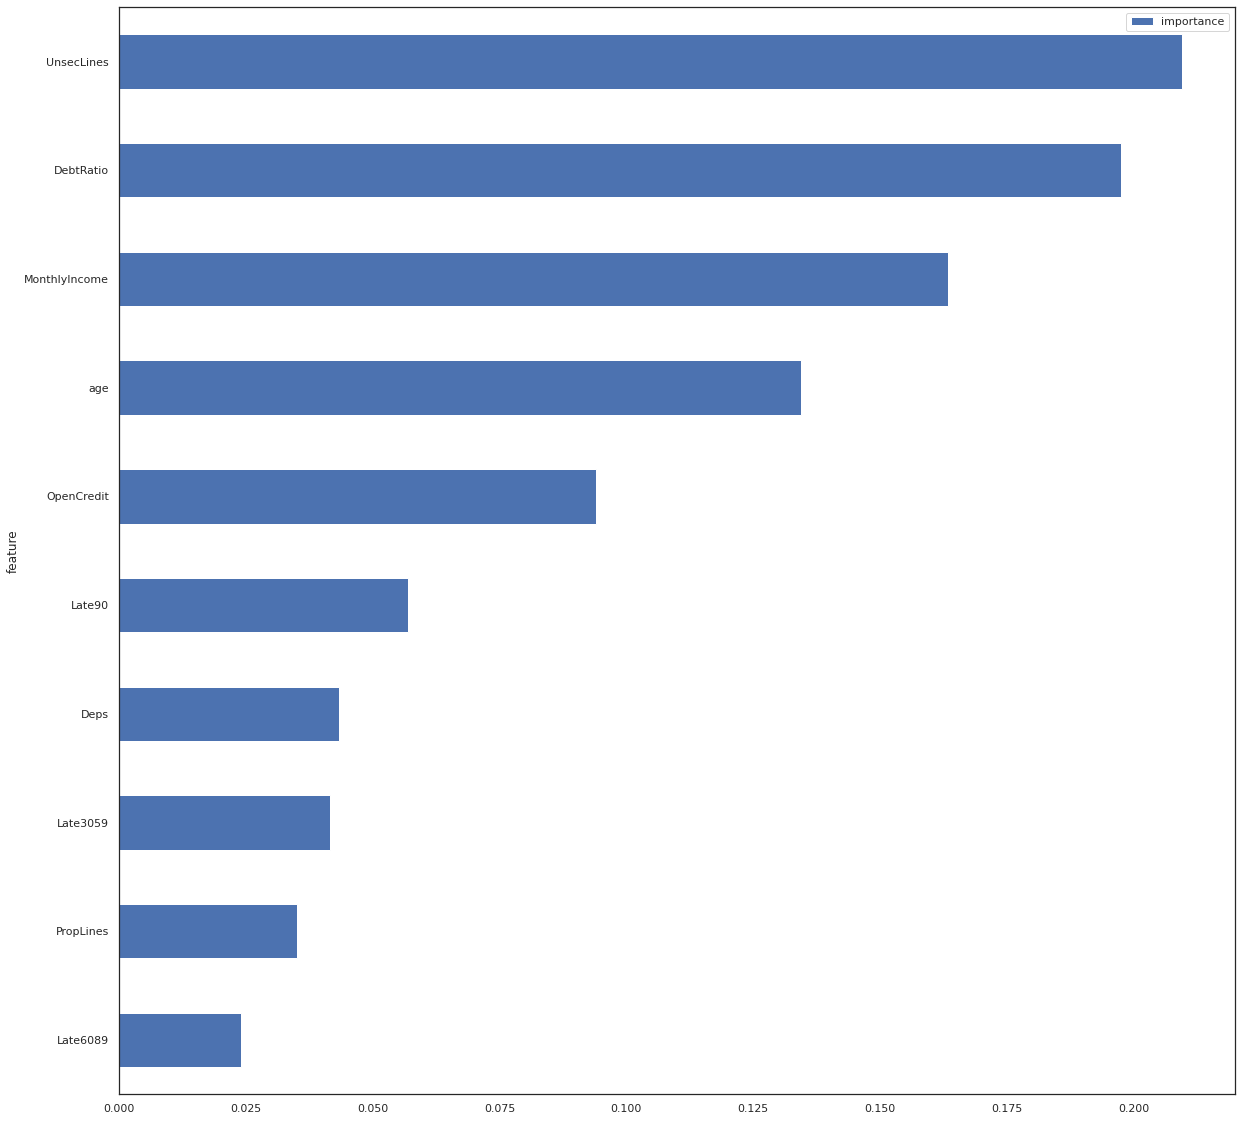

In [692]:
features.plot(kind='barh', figsize=(20, 20))

In [693]:
test_df = test_df.rename(columns={'Unnamed: 0': 'Unknown'})

In [694]:
results_df = test_df.drop(['UnsecLines','age','Late3059','DebtRatio','MonthlyIncome','OpenCredit', 'Late90',
                        'PropLines', 'Late6089', 'Deps'], axis=1)

In [695]:
results_df.head()

,Unknown,Target
0,1,NaN
1,2,NaN
2,3,NaN
3,4,NaN
4,5,NaN


In [696]:
model = RandomForestClassifier(n_estimators=15, max_depth=6, random_state=0)
model.fit(X_train, Y_train)
# y_pred = model.predict_proba(test_df.drop(["Unknown"], axis=1))
y_pred = model.predict_proba(test_df.drop(["Unknown","Target"], axis=1))
y_pred = y_pred[:,1]
results_df.Target = y_pred

In [697]:
y_pred

array([0.09170992, 0.04745981, 0.01968301, ..., 0.0103965 , 0.10458805,
       0.0327474 ])

In [698]:
results_df = results_df.rename(columns={'Unknown': 'Id',
                                        'Target': 'Probability'})
results_df.head()

,Id,Probability
0,1,0.091710
1,2,0.047460
2,3,0.019683
3,4,0.052989
4,5,0.101161


In [699]:
results_df.to_csv("KAGGLE_CREDIT_SCORE.csv", index=False)